<a href="https://colab.research.google.com/github/ravuribhargav/Question-Paper-Difficulty-Analysis/blob/main/Question_Paper_Difficulty_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Paper Difficulty Analysis (NLP + OCR)
**Goal:** Extract questions from **question paper images** using OCR and classify each question as **Easy / Medium / Hard**.

## What this notebook does
1. Reads input files (works in **Google Colab** and **Local/GitHub**)
2. Performs OCR (OpenCV + Tesseract)
3. Cleans text and segments questions
4. Uses TF‑IDF + Logistic Regression to predict difficulty
5. Produces a final report + charts + exports

## How to run
### Local / GitHub
- Create a folder named `data/` in the repo
- Put your question paper images (`.jpg/.png/.jpeg`) inside `data/`
- Run all cells

### Google Colab
- Run the notebook
- Upload images when prompted


## 1️⃣ Setup (Colab only)
**Note:** The cell below installs Tesseract + Python libraries in **Google Colab**.
If you're running locally, install requirements separately (see `requirements.txt`).

In [ ]:
!apt-get -qq update
!apt-get -qq install -y tesseract-ocr
!pip -q install pytesseract pillow pandas matplotlib


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## 2️⃣ Install dependencies (Colab)
Run this **only in Colab**.

## 3️⃣ Imports

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image


## 4️⃣ Input handling + OCR (Colab + Local/GitHub)
Uploads images in Colab, or reads from `data/` folder locally.

In [ ]:
import os, glob
import cv2
import pytesseract

# ----------------------------
# 1) Detect environment (Colab vs Local)
# ----------------------------
IN_COLAB = False
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False


# ----------------------------
# 2) Get image file list
#    - Colab: upload images
#    - Local/GitHub: read from data/ folder
# ----------------------------
def get_image_files():
    if IN_COLAB:
        print("✅ Running in Google Colab")
        print("📌 Please upload images (jpg/png/jpeg)")
        uploaded = files.upload()
        file_names = list(uploaded.keys())

    else:
        print("✅ Running locally / GitHub")
        folder = "data/sample/"
        file_names = (
            glob.glob(os.path.join(folder, "*.png")) +
            glob.glob(os.path.join(folder, "*.jpg")) +
            glob.glob(os.path.join(folder, "*.jpeg"))
        )

    # filter only valid image extensions
    file_names = [f for f in file_names if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    if not file_names:
        raise FileNotFoundError(
            "❌ No image files found.\n"
            "👉 Colab: upload images when prompted.\n"
            "👉 Local/GitHub: put images in a folder named 'data/'"
        )

    print("📂 Images found:", file_names)
    return file_names


# ----------------------------
# 3) OCR Preprocessing
# ----------------------------
def preprocess_for_ocr(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Could not read image: {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    thresh = cv2.medianBlur(thresh, 3)
    return thresh


def ocr_image(image_path):
    processed = preprocess_for_ocr(image_path)
    config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(processed, config=config)

    # fallback if weak output
    if len(text.strip()) < 20:
        config2 = r'--oem 3 --psm 4'
        text = pytesseract.image_to_string(processed, config=config2)

    return text


# ----------------------------
# 4) Run OCR on all images
# ----------------------------
file_names = get_image_files()

raw_text_all = ""
for fn in file_names:
    print("🔍 OCR Running for:", fn)
    page_text = ocr_image(fn)
    raw_text_all += "\n\n" + page_text

print("\n✅ OCR OUTPUT (first 2500 chars):\n")
print(raw_text_all[:2500])


✅ Running in Google Colab
📌 Please upload images (jpg/png/jpeg)


Saving third_page.jpg to third_page.jpg
Saving second_page.jpg to second_page.jpg
Saving first page.jpg to first page.jpg
📂 Images found: ['third_page.jpg', 'second_page.jpg', 'first page.jpg']
🔍 OCR Running for: third_page.jpg
🔍 OCR Running for: second_page.jpg
🔍 OCR Running for: first page.jpg

✅ OCR OUTPUT (first 2500 chars):



?
(OR)
9. (2) Explain about formatting title, caption and
reference lines in Tableau. (7M) CO4
(b) Illustrate with an example how to add change
parameter and change set values actions in
dashboard/worksheet in Tableau. (7M) CO4
essen
CD315(JOEL26) (R20)
3


(OR)
3. (a) Explain cyclical process of a business
intelligence analysis. (7M) COl
(b) Wnte about Business Performance
Management. (7M) COl
UNIT - Il
4. (a) How to create bivariate charts in tableau with
examples. (7M) CO2
(b) Differentiate between a tree and heat map. (7M) CO2
(OR)
5. (a) How to perform swapping rows and columns in
bivariate charts using tableau with example. (7M) CO2
(b) How to use pol

## 5️⃣ Text cleaning + Question segmentation

In [ ]:
def clean_text_final(text: str) -> str:
    text = text.replace("\x0c", " ")

    # ✅ Remove headers/footers lines
    header_patterns = [
        r'^Hall Ticket.*$',
        r'^CD\d+.*$',
        r'^B\.TECH\..*$',
        r'^Semester.*$',
        r'^BUSINESS INTELLIGENCE TOOLS.*$',
        r'^Time:.*$',
        r'^Answer Question.*$',
        r'^\s*\d+\s*$'     # page numbers alone like 3
    ]
    for pat in header_patterns:
        text = re.sub(pat, '', text, flags=re.IGNORECASE | re.MULTILINE)

    # ✅ Remove CO/col tags even with OCR mistakes
    co_patterns = [
        r'\bCO\s*\d+\b',       # CO1 CO2 CO3
        r'\bCO\s*!\b',         # CO!
        r'\bCO\s*!',           # CO! with trailing
        r'\bC\s*O\s*!\b',       # C O !
        r'\bCO[Il]\b',         # COl COI
        r'\bcol\b',            # col
        r'\bco\s*\d+\b',       # co2
        r'\bCco\s*\d+\b',      # Cco2
        r'\bCcO\s*\d+\b',      # CcO2
        r'\bC0\d\b'            # C02 C03
    ]
    for pat in co_patterns:
        text = re.sub(pat, '', text, flags=re.IGNORECASE)

    # ✅ Remove junk lines / words
    text = re.sub(r'^\s*\?\s*$', '', text, flags=re.MULTILINE)  # removes single '?'
    text = re.sub(r'\bessen\b', '', text, flags=re.IGNORECASE)  # removes 'essen'

    # ✅ Fix OCR mistake: UNIT - I l  => UNIT - II
    text = re.sub(r'UNIT\s*-\s*I\s*l', 'UNIT - II', text, flags=re.IGNORECASE)

    # ✅ Fix UNIT - HI => UNIT - III
    text = re.sub(r'UNIT\s*-\s*HI\b', 'UNIT - III', text, flags=re.IGNORECASE)

    # ✅ Fix Q9: "9. (2)" => "9. (a)"
    text = re.sub(r'(9\.)\s*\(\s*2\s*\)', r'\1 (a)', text)

    # ✅ Fix: G) -> (i) , Gj) -> (j), (1)->(l)
    text = re.sub(r'^\s*G\)\s*', '(i) ', text, flags=re.MULTILINE)
    text = re.sub(r'^\s*Gj\)\s*', '(j) ', text, flags=re.MULTILINE)
    text = re.sub(r'\(\s*1\s*\)', '(l)', text)

    # ✅ remove extra spaces / newlines
    text = re.sub(r'[ \t]+', ' ', text)
    text = re.sub(r'\n+', '\n', text)

    return text.strip()


cleaned_text = clean_text_final(raw_text_all)
print(cleaned_text[:2500])


(OR)
9. (a) Explain about formatting title, caption and
reference lines in Tableau. (7M) 
(b) Illustrate with an example how to add change
parameter and change set values actions in
dashboard/worksheet in Tableau. (7M) 
(OR)
3. (a) Explain cyclical process of a business
intelligence analysis. (7M) 
(b) Wnte about Business Performance
Management. (7M) 
UNIT - II
4. (a) How to create bivariate charts in tableau with
examples. (7M) 
(b) Differentiate between a tree and heat map. (7M) 
(OR)
5. (a) How to perform swapping rows and columns in
bivariate charts using tableau with example. (7M) 
(b) How to use polygon shapes for visualization
using tableau. (7M) 
UNIT - III
6. (a) Explain Number and String functions with
examples in Tableau. (7M) 
(b) Write about Color, Size, Text, Detail and
ToolTip in marks card with examples. (7M) 
(OR)
7. Explain Date and Type functions with examples in
Tableau. 
UNIT - IV
8. (a) What is the difference between Joining and
Blending? (7M) 
(b) What are the fi

In [ ]:
import re

# -----------------------------
# Helpers
# -----------------------------
def normalize_unit(raw: str | None) -> str | None:
    """OCR unit normalization if you want to use it (optional)."""
    if not raw:
        return None
    u = raw.strip().upper()

    # common OCR mistakes
    u = u.replace("I V", "IV")
    u = u.replace("1V", "IV")
    u = u.replace("LV", "IV")

    if u == "HI":
        u = "III"

    if u not in {"I", "II", "III", "IV"}:
        return None
    return u


def infer_unit_from_qno(qno: int) -> str | None:
    """
    ✅ Reliable unit mapping based on fixed exam structure
    2-3 => UNIT I
    4-5 => UNIT II
    6-7 => UNIT III
    8-9 => UNIT IV
    """
    if 2 <= qno <= 3:
        return "I"
    if 4 <= qno <= 5:
        return "II"
    if 6 <= qno <= 7:
        return "III"
    if 8 <= qno <= 9:
        return "IV"
    return None


def next_subpart_letter(letter: str) -> str:
    c = (letter or "a").lower()
    if c == "z":
        return "z"
    return chr(ord(c) + 1)


def clean_question_text(q: str) -> str:
    """Cleans question text from OCR junk + normalizes marks."""
    q = q.strip()

    # remove embedded UNIT in same line
    q = re.sub(r'UNIT\s*-\s*[A-Za-z0-9]+', '', q, flags=re.IGNORECASE)

    # normalize marks
    q = re.sub(r'\(\s*7\s*\)', '(7M)', q)

    # remove OCR arrows
    q = q.replace("(>)", " ")
    q = q.replace(">", " ")

    # ✅ Remove CO tags (CO], CO}, CO1, etc.)
    q = re.sub(r'\bCO[\]\}\)\|]?\s*\d*\b', '', q, flags=re.IGNORECASE)

    # ✅ Remove Subject header noise
    q = re.sub(r'\bMACHINE\s+LEARNING\b', '', q, flags=re.IGNORECASE)

    # ✅ Remove random junk words
    q = re.sub(r'\bseee+\b', '', q, flags=re.IGNORECASE)
    q = re.sub(r'\bsee+\b', '', q, flags=re.IGNORECASE)

    # ✅ Remove garbage OCR continuation text (headers/footers)
    junk_patterns = [
        r'Answer One Question from each unit.*',
        r'Answer Question No\.?1.*',
        r'Answer the following.*',
        r'Maximum Marks.*',
        r'Time:.*',
        r'B\.TECH\..*',
        r'CD\d+.*',
        r'(?:PT\s*){2,}.*',      # repeated PT
        r'(?:TT\s*){3,}.*',      # repeated TT
        r'(?:TTT\s*){2,}.*',     # repeated TTT
    ]
    for pat in junk_patterns:
        q = re.sub(pat, '', q, flags=re.IGNORECASE)

    # whitespace
    q = re.sub(r'\s+', ' ', q).strip()
    return q


# ✅ Sorting helper (QID sorting)
def qid_sort_key(qid: str):
    """
    Convert qid into sortable key:
      1(a) -> (1,1)
      1(n) -> (1,14)
      7 -> (7,0)
      9(b) -> (9,2)
    """
    qid = qid.strip().lower()

    m = re.match(r'^(\d+)(?:\(([a-z])\))?$', qid)
    if not m:
        return (999, 999)

    qno = int(m.group(1))
    sub = m.group(2)

    if not sub:
        return (qno, 0)

    sub_no = ord(sub) - ord("a") + 1
    return (qno, sub_no)


# ✅ NEW: Split merged one-mark subquestions like:
# 1(k) ... (Il) Define ...  => 1(k) ... , 1(l) Define ...
def split_q1_merged_subparts(items):
    fixed = []
    for item in items:
        qid = item["qid"]
        q = item["question"]
        unit = item["unit"]

        # Only apply for Q1 parts: 1(a)...1(n)
        if qid.startswith("1("):
            # Detect embedded (l) / (Il) / (1)
            m = re.search(r'\(\s*(Il|l|1)\s*\)\s*', q)
            if m:
                split_pos = m.start()
                part1 = q[:split_pos].strip()
                part2 = q[split_pos:].strip()

                # Normalize (Il) or (1) -> (l)
                part2 = re.sub(r'^\(\s*(Il|1)\s*\)', '(l)', part2).strip()
                part2 = re.sub(r'^\(\s*l\s*\)\s*', '', part2).strip()

                # determine next QID (k -> l)
                base_match = re.match(r'^1\(([a-z])\)$', qid.lower())
                if base_match:
                    current_sub = base_match.group(1)
                    next_sub = chr(ord(current_sub) + 1)

                    fixed.append({"qid": qid, "question": clean_question_text(part1), "unit": unit})
                    fixed.append({"qid": f"1({next_sub})", "question": clean_question_text(part2), "unit": unit})
                    continue

        fixed.append({"qid": qid, "question": clean_question_text(q), "unit": unit})

    return fixed


# -----------------------------
# MAIN SEGMENTATION FUNCTION
# -----------------------------
def segment_questions_with_ids_final(text: str):
    lines = [ln.strip() for ln in text.split("\n") if ln.strip()]

    unit = None
    qno = None
    results = []

    # ---- STEP 1: Basic segmentation ----
    for ln in lines:

        # UNIT heading detection (optional)
        unit_match = re.match(r'^UNIT\s*-\s*([A-Za-z0-9]+)', ln, flags=re.IGNORECASE)
        if unit_match:
            unit = normalize_unit(unit_match.group(1))
            continue

        # skip OR
        if ln.upper() == "(OR)":
            continue

        # main question lines like "3. (a) ..." or "7. Explain ..."
        q_match = re.match(r'^(\d+)\.\s*(.*)', ln)
        if q_match:
            qno = q_match.group(1)
            remainder = q_match.group(2).strip()

            if "answer the following" in remainder.lower():
                continue

            # if remainder contains subquestion inline
            sub_inline = re.match(r'^\(\s*([a-zA-Z])\s*\)\s*(.*)', remainder)
            if sub_inline:
                sub = sub_inline.group(1).lower()
                ques = sub_inline.group(2).strip()

                # OCR fix: (v) mistaken for (b) in Q1
                if qno == "1" and sub == "v":
                    sub = "b"

                results.append({
                    "qid": f"{qno}({sub})",
                    "question": clean_question_text(ques),
                    "unit": unit
                })
            else:
                # direct question like "7. Explain ..."
                if remainder:
                    results.append({
                        "qid": qno,
                        "question": clean_question_text(remainder),
                        "unit": unit
                    })
            continue

        # subquestion only line "(a) ..."
        sub_match = re.match(r'^\(\s*([a-zA-Z])\s*\)\s*(.*)', ln)
        if sub_match and qno is not None:
            sub = sub_match.group(1).lower()
            ques = sub_match.group(2).strip()

            if qno == "1" and sub == "v":
                sub = "b"

            results.append({
                "qid": f"{qno}({sub})",
                "question": clean_question_text(ques),
                "unit": unit
            })
            continue

        # continuation line
        if results:
            results[-1]["question"] = clean_question_text(results[-1]["question"] + " " + ln)

    # ---- STEP 2: Fix duplicate qids + FORCE correct unit mapping ----
    fixed = []
    seen = set()
    last_sub_used = {}

    for item in results:
        qid = item["qid"]
        q = item["question"]
        u = item["unit"]

        # ✅ FORCE UNIT mapping ONLY for Q2–Q9
        mnum = re.match(r'^(\d+)', qid)
        if mnum:
            qnum_int = int(mnum.group(1))
            if 2 <= qnum_int <= 9:
                mapped = infer_unit_from_qno(qnum_int)
                if mapped is not None:
                    u = mapped
            else:
                u = None  # Q1 must have no unit

        # Fix duplicate subparts
        m = re.match(r'^(\d+)\(([a-z])\)$', qid)
        if m:
            base = m.group(1)
            sub = m.group(2)

            if base not in last_sub_used:
                last_sub_used[base] = set()

            while qid in seen or sub in last_sub_used[base]:
                sub = next_subpart_letter(sub)
                qid = f"{base}({sub})"

            last_sub_used[base].add(sub)

        seen.add(qid)
        fixed.append({"qid": qid, "question": q, "unit": u})

    # ✅ NEW STEP: split merged one-mark (Il) problem
    fixed = split_q1_merged_subparts(fixed)

    # ---- STEP 3: Split any question having 2×(7M) into two subquestions ----
    final = []
    for item in fixed:
        qid = item["qid"]
        q = item["question"]
        u = item["unit"]

        matches = list(re.finditer(r'\(7M\)', q, flags=re.IGNORECASE))
        if len(matches) >= 2:
            cut = matches[0].end()
            part1 = q[:cut].strip()
            part2 = q[cut:].strip()
            part2 = re.sub(r'^[^A-Za-z]+', '', part2).strip()

            # next qid
            m = re.match(r'^(\d+)\(([a-z])\)$', qid)
            if m:
                base, sub = m.group(1), m.group(2)
                qid2 = f"{base}({next_subpart_letter(sub)})"
            else:
                qid2 = qid + "(b)"

            final.append({"qid": qid, "question": clean_question_text(part1), "unit": u})
            final.append({"qid": qid2, "question": clean_question_text(part2), "unit": u})
        else:
            final.append(item)

    # ---- STEP 4: Sort by question number order ----
    final = sorted(final, key=lambda x: qid_sort_key(x["qid"]))

    return final


# ✅ RUN SEGMENTATION
segmented = segment_questions_with_ids_final(cleaned_text)

print("Total segmented questions:", len(segmented))
for item in segmented[:60]:
    print(item)


Total segmented questions: 29
{'qid': '1(a)', 'question': 'List the main purpose of Data Warehouse.', 'unit': None}
{'qid': '1(b)', 'question': 'Define User Interface in BI.', 'unit': None}
{'qid': '1(c)', 'question': 'List the phases in the cyclical process of a Business Intelligence analysis.', 'unit': None}
{'qid': '1(d)', 'question': 'Define Business Intelligence.', 'unit': None}
{'qid': '1(e)', 'question': 'Identify one chart type commonly used to display the distribution of numerical data in Tableau.', 'unit': None}
{'qid': '1(f)', 'question': 'Define Gantt chart in Tableau.', 'unit': None}
{'qid': '1(g)', 'question': 'How to customize maps in Tableau?', 'unit': None}
{'qid': '1(h)', 'question': 'What are the supported data types in Tableau’?', 'unit': None}
{'qid': '1(i)', 'question': 'How can predefined fields be utilized in data analysis within a tool like Tableau?', 'unit': None}
{'qid': '1(j)', 'question': 'Define the concept of discretizing data and provide an example of it

In [ ]:
import pandas as pd

df = pd.DataFrame(segmented)
df.head(30)


,qid,question,unit
0,1(a),List the main purpose of Data Warehouse.,None
1,1(b),Define User Interface in BI.,None
2,1(c),List the phases in the cyclical process of a B...,None
3,1(d),Define Business Intelligence.,None
4,1(e),Identify one chart type commonly used to displ...,None
5,1(f),Define Gantt chart in Tableau.,None
6,1(g),How to customize maps in Tableau?,None
7,1(h),What are the supported data types in Tableau’?,None
8,1(i),How can predefined fields be utilized in data ...,None
9,1(j),Define the concept of discretizing data and pr...,None


## 6️⃣ Feature extraction + Model training

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")   # ✅ NEW FIX
nltk.download("averaged_perceptron_tagger")
# TF-IDF NLP
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=1500)
X = tfidf.fit_transform(df["question"])

# difficulty score using tfidf complexity + length
# (More meaningful words + longer question => harder)
df["tfidf_sum"] = X.sum(axis=1).A1
df["word_count"] = df["question"].apply(lambda x: len(nltk.word_tokenize(x)))

# normalize
df["tfidf_norm"] = (df["tfidf_sum"] - df["tfidf_sum"].min()) / (df["tfidf_sum"].max() - df["tfidf_sum"].min() + 1e-9)
df["len_norm"]   = (df["word_count"] - df["word_count"].min()) / (df["word_count"].max() - df["word_count"].min() + 1e-9)

# combined score
df["score"] = 0.6*df["tfidf_norm"] + 0.4*df["len_norm"]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## 7️⃣ Overall paper difficulty score

In [ ]:
def label_score_fixed(s):
    if s < 0.35:
        return "Easy"
    elif s < 0.70:
        return "Medium"
    return "Hard"

df["difficulty"] = df["score"].apply(label_score_fixed)
print(df["difficulty"].value_counts())


difficulty
Easy      14
Medium    11
Hard       4
Name: count, dtype: int64


In [ ]:
weights = {"Easy": 1, "Medium": 2, "Hard": 3}
paper_score = df["difficulty"].map(weights).mean()

if paper_score < 1.7:
    overall = "Easy"
elif paper_score < 2.4:
    overall = "Medium"
else:
    overall = "Hard"

print("Paper Difficulty Score:", round(paper_score, 3))
print("Overall Paper Difficulty:", overall)


Paper Difficulty Score: 1.655
Overall Paper Difficulty: Easy


## 8️⃣ Visualization

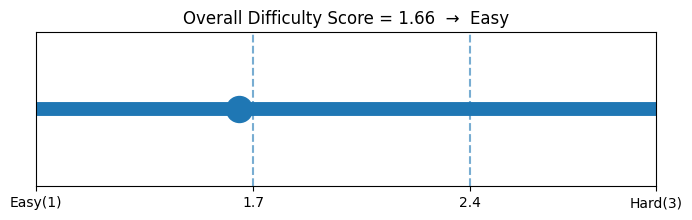

In [ ]:
import os
import matplotlib.pyplot as plt

# ✅ Detect Colab
IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


plt.figure(figsize=(8, 2))
plt.hlines(1, 1, 3, linewidth=10)
plt.scatter([paper_score], [1], s=350)

plt.xlim(1, 3)
plt.yticks([])
plt.xticks([1, 1.7, 2.4, 3], ["Easy(1)", "1.7", "2.4", "Hard(3)"])

plt.axvline(1.7, linestyle="--", alpha=0.6)
plt.axvline(2.4, linestyle="--", alpha=0.6)

plt.title(f"Overall Difficulty Score = {paper_score:.2f}  →  {overall}")

# ✅ Save ONLY in GitHub/local, NOT in Colab
if not IN_COLAB:
    os.makedirs("outputs", exist_ok=True)
    plt.savefig("outputs/overall_difficulty_score.png", bbox_inches="tight")

plt.show()


## 9️⃣ Export outputs
The following cell saves results so GitHub users can find them easily.

In [ ]:
import os
os.makedirs("outputs", exist_ok=True)

# ✅ Export question-level predictions
df.to_csv("outputs/question_difficulty_results.csv", index=False)
print("✅ Saved: outputs/question_difficulty_results.csv")


✅ Saved: outputs/question_difficulty_results.csv


## ✅ Final report

In [ ]:
print("="*55)
print("FINAL QUESTION PAPER DIFFICULTY REPORT")
print("="*55)
print("Total Questions:", len(df))
print(df["difficulty"].value_counts())
print("-"*55)
print("Paper Score:", round(paper_score, 2))
print("Overall Difficulty:", overall)
print("="*55)


FINAL QUESTION PAPER DIFFICULTY REPORT
Total Questions: 29
difficulty
Easy      14
Medium    11
Hard       4
Name: count, dtype: int64
-------------------------------------------------------
Paper Score: 1.66
Overall Difficulty: Easy
